In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

/content/drive/MyDrive/Yeast


### *Hàm cắt ảnh chỉ giữ lại phần cần thiết*

In [4]:
from google.colab.patches import cv2_imshow

In [5]:
def cut_unecessary_img(head_path,input_paths,save_paths):
  for i in len(input_paths):
    image = cv2.imread(os.path.join(head_path, input_paths[i]))
    cv2_imshow(image)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    threshold_value = 185
    ret, thresholded_imaged = cv2.threshold(gray_image, threshold_value, 255, cv2.THRESH_BINARY)

    thresholded_image = cv2.bitwise_not(thresholded_image)

    contours, _ = cv2.findContours(thresholded_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    mask = np.zeros_like(gray_image)

    new_contours = ()

    MIN_HEIGHT = image.shape[1] * 0.5
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if h >= MIN_HEIGHT:
            new_contours += (cnt,)
    con = new_contours[0]
    cv2.drawContours(mask, [con], -1, (255), thickness=cv2.FILLED)
    x ,y,w,h = cv2.boundingRect(con)
    # # Apply the mask to the original image
    result = cv2.bitwise_and(image, image, mask=mask)
    # cv2_imshow(result)
    result = result[y:y+1536,x:x+1536]
    cv2_imshow(result)
    # Display the result
    save_path = os.path.join(head_path, "croped_" + input_paths[i])
    cv2.imwrite(save_path, result)


### *Padding cho ảnh nếu kích thước k đủ 1536x1536*

In [6]:
def pad_image(img_path, target_size):
    image = cv2.imread(img_path)
    H, W = image.shape[:2]
    target_H, target_W = target_size

    pad_height = max(0, target_H - H)
    pad_width = max(0, target_W - W)

    padded_image = np.pad(image, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant')

    padded_image = padded_image[:target_H, :target_W, :]
    print(padded_image.shape)
    cv2.imwrite(img_path, padded_image)


### *crop từng tế bào con*

In [9]:
def crop_img(head_img, head_mask,img_path,save_path,i):
    image_path = os.path.join(head_img,img_path)
    mask_path = os.path.join(head_mask,img_path)
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    # Tìm các đường viền trên mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    dem = 0
    MIN_WIDTH = 4
    MAX_HEIGHT = img.shape[1] * 0.25

    for contour in contours:
      x, y, w, h = cv2.boundingRect(contour)
      if w >= MIN_WIDTH and h < MAX_HEIGHT:
          dem += 1
          cropped_image = image[y:y+h, x:x+w]
          endwith = str(i) + "_{}.png".format(dem)
          save_path = os.path.join(save_path, endwith)
          cv2.imwrite(save_path, cropped_image)

In [8]:
images = os.listdir("BackTest/2h")
images

['F1-B1-2h-01.jpeg',
 'F1-B1-2h-06.jpeg',
 'F1-B1-2h-11.jpeg',
 'F1-B1-2h-10.jpeg',
 'F1-B1-2h-12.jpeg',
 'F1-B1-2h-05.jpeg',
 'F1-B1-2h-02.jpeg',
 'F1-B1-2h-09.jpeg',
 'F1-B1-2h-08.jpeg',
 'F1-B1-2h-04.jpeg',
 'F1-B1-2h-03.jpeg',
 'F1-B1-2h-07.jpeg']

In [ ]:
crop_files = os.listdir("Backtest/2h")
len(crop_files)

744

In [ ]:
img = cv2.imread("BackTest/2h/F1-B1-2h-07.jpeg", cv2.IMREAD_GRAYSCALE)
mask = cv2.imread("BackTest/mask2h/F1-B1-2h-07.jpeg", cv2.IMREAD_GRAYSCALE)
_, thresh = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

In [ ]:
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

In [ ]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1
markers[unknown == 255] = 0


In [ ]:
img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
markers = cv2.watershed(img_color, markers)
img_color[markers == -1] = [255, 0, 0]

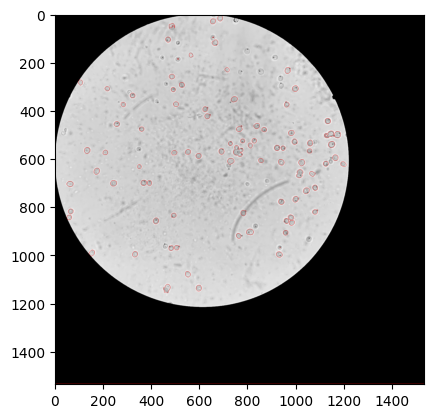

In [ ]:
plt.imshow(img_color)